## Batch 4 - loci with fixed differences between eastern and western Pacific cod

<br>
In this notebook, I will identify loci from batch 4 of the stacks pipeline that have fixed differences in allele frequencies between eastern and western Pacific cod populations. 

Specifically, the notebook contains:
1. running the batch 4 unfiltered genepop file through Genepop program for (a) allele frequencies, and (b) FST
2. ranking of loci based on FST value to identify potentially informative loci
3. checking allele frequencies of top ranked loci from (2)

There are also helpful graphs along the way

<br>
<br>

Programs used: 
1. Stacks v1.44 (windows)
2. Genepop v4.2 (windows)
3. Python 2.7 (linux)

<br>
#### Date: 11/3/2017

<br>


### Genepop: FST and Allele Frequencies

GENEPOP FILE: batch_4_EastWest_genepop.txt

In Genepop: `Option 5 >> Suboption 1: Allele and genotype frequencies per locus and per sample` returns a `.INF` file.

In Genepop: `Option 6 >> Suboption 1: Allele identity (F-statistics) For all populations` returns a `.FST` file.

<br>
### Parsing Genepop Output: Rank Loci by FST

In [1]:
pwd

u'/mnt/hgfs/PCod-Korea-repo/notebooks'

In [2]:
cd ../

/mnt/hgfs/PCod-Korea-repo


In [4]:
cd ../PCod-Compare-repo/

/mnt/hgfs/PCod-Compare-repo


In [26]:
# open genepop output file, new text file to write to
infile = open("stacks_b4_wgenome/batch_4_EastWest_genepop.txt.FST", "r")
outfile = open("analyses/batch_4_EastWest_FSTrankedLoci.txt", "w")
outfile_nofst = open("analyses/batch_4_EastWest_Loci_noFST.txt", "w")

# skip through the input file until the summary table at the end
line = infile.readline()
while not line.startswith("Multilocus estimates for diploid data"):
    line = infile.readline()

# copy over heading of the summary table
heading = infile.readline()
heading_list = heading.strip().split()
outfile.write("\t".join(heading_list) + "\n")
outfile_nofst.write("\t".join(heading_list) + "\n")
infile.readline()

# initiate dictionary: key = FST, value = list of loci with that FST
fst_dict = {}

for line in infile:
    # extract locus name and fst value from line
    linelist = line.strip().split()
    if "All" in line:
        break
    locus = linelist[0]
    # if the locus has an FST value (it is present in both groups)
    if linelist[2] != "-":
        fst = float(linelist[2])
        # if the fst already exists in dictionary, add locus to value list. otherwise, initiate a new entry
        if fst in fst_dict.keys():
            loci = fst_dict[fst]
            loci.append(locus)
            fst_dict[fst] = loci
        elif fst not in fst_dict.keys():
            fst_dict[fst] = [locus]
    elif linelist[2] == "-":
        outfile_nofst.write(line)
infile.close()

In [27]:
outfile_nofst.close()

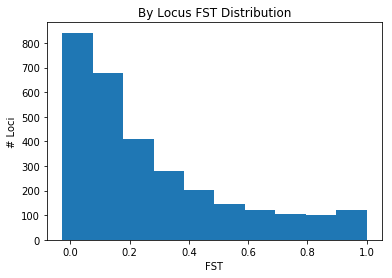

In [28]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(fst_dict.keys())
plt.title("By Locus FST Distribution")
plt.xlabel("FST")
plt.ylabel("# Loci")
plt.show()

In [29]:
plt.close()

In [30]:
# sort the FST values, and write to output file in order. each locus gets its own line, even with = FST.
fst_list = fst_dict.keys()
fst_list.sort()

for fst in fst_list:
    # if only one locus has that fst value
    if len(fst_dict[fst]) == 1:
        locus = str(fst_dict[fst]).replace("'",'').replace("]",'').replace("[",'') 
        outfile.write(locus + "\t" + str(fst) + "\n")
    # or if several loci have that fst value
    else: 
        loci = fst_dict[fst]
        for i in loci:
            outfile.write(i + "\t" + str(fst) + "\n")
outfile.close()

In [32]:
cd analyses

/mnt/hgfs/PCod-Compare-repo/analyses


<br>
<br>

### Investigate allele frequencies of the top 20 loci with highest FST values

I copied over (manually) allele frequency tables from the genepop `.INF` file for the following loci:

In [39]:
!tail -n 15 batch_4_EAstWest_FSTrankedLoci.txt

1459_47	0.995
24773_38	0.995
15292_68	0.9953
25325_80	0.9965
7855_73	0.9984
24890_81	0.9984
7965_28	1.0
8300_38	1.0
9026_39	1.0
9465_77	1.0
18109_59	1.0
18875_90	1.0
19949_41	1.0
21250_76	1.0
21790_38	1.0


<br>
<br>
### Make fasta file with sequences for loci

In [40]:
loci_of_interest = ["1459_47",
"24773_38",
"15292_68",
"25325_80",
"7855_73",    
"24890_81",
"7965_28",
"8300_38",
"9026_39",
"9465_77",
"18109_59",
"18875_90",
"19949_41",
"21250_76",
"21790_38"]

In [41]:
cd ../

/mnt/hgfs/PCod-Compare-repo


In [44]:
fasta = open("results/PCod_batch_4_AKvKOR_fixedloci_sequences.fasta", "w")
catfile = open("stacks_b4_wgenome/batch_4.catalog.tags.tsv", "r")
catfile.readline() # if there is a header

# the loci of interest list has both the locus ID and the SNP position. This code splits them into separate lists
loci_list = []
pos_list = []
for locus in loci_of_interest:
    ref = locus.split("_")[0]
    pos = locus.split("_")[1]
    loci_list.append(ref)
    pos_list.append(pos)

# now I can run through the catalog file and extract consensus seqences
loci_written = 0
for line in catfile:
    locus = line.strip().split()[2]
    if locus in loci_list:
        seq = line.strip().split()[9]
        i = loci_list.index(locus)
        fasta.write(">" + loci_list[i] + "_" + pos_list[i] + "\n")
        fasta.write(seq + "\n")
        loci_written += 1
catfile.close()

print "Needed to copy: ", len(loci_of_interest), " loci."
print "Actually copied: ", str(loci_written), " loci."

Needed to copy:  15  loci.
Actually copied:  15  loci.


<br>
<br>
### File with allele frequencies: 
PCod_batch_4_AKvKOR_fixedloci_AlleleFrequencies.txt


In [46]:
!head results/PCod_batch_4_AKvKOR_fixedloci_AlleleFrequencies.txt

### Fasta file with sequences:
PCod_batch_4_AKvKOR_fixedloci_sequences.fasta


In [48]:
!head -n 2 results/PCod_batch_4_AKvKOR_fixedloci_sequences.fasta

>1459_47
TGCAGGGGTGTTCTCGCCATGAGAACTTTAAATTCTCATGGCGAAATTGATTCCAATGAGACCGTTTTCCGGTCATTTTCTTTTTGCCCGGC
